In [329]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import os
# print(os.getcwd())

In [330]:

# --- Load CSV ---
csv_path = "../../results/merged_output_finished.csv"
df = pd.read_csv(csv_path) 

# --- Basic Cleanup ---
df.columns = df.columns.str.strip()

In [331]:
# Ensure correct dtypes
bool_cols = ["judge_answer_correctness_vs_ref", "judge_answer_helpfulness"]
for col in bool_cols:
    if df[col].dtype != bool:
        df[col] = df[col].astype(str).str.lower().isin(["true", "1", "yes"])

numeric_cols = ["meta_total_tokens", "cosine", "rougeL", "bleu"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

In [332]:

# --- Clean up total_elapsed_time column ---
def parse_seconds(x):
    """Convert strings like '12 seconds' or '1.5 s' to float seconds."""
    if pd.isna(x):
        return None
    import re
    match = re.search(r"([\d\.]+)", str(x))
    return float(match.group(1)) if match else None

df["total_elapsed_time_sec"] = df["total_elapsed_time"].apply(parse_seconds)


# --- Add price per run ---
def compute_price(row):
    """
    Compute cost (in USD) based on model type and total tokens.
    Prices per 1M tokens:
      - gpt-nano: $0.40
      - gpt-mini: $2.00
    """
    tokens = row.get("meta_total_tokens", 0)
    model = str(row.get("model", "")).lower()
    
    if "nano" in model:
        price_per_million = 0.40
    elif "mini" in model:
        price_per_million = 2.00
    else:
        # Default if model not recognized
        price_per_million = 1.00  

    return (tokens / 1_000_000) * price_per_million

df["price_usd"] = df.apply(compute_price, axis=1)

# --- Group and Aggregate ---
group_cols = ["approach", "model", "top_k"]

agg_df = (
    df.groupby(group_cols)
      .agg(
          avg_meta_total_tokens=("meta_total_tokens", "mean"),
          avg_cosine=("cosine", "mean"),
          avg_rougeL=("rougeL", "mean"),
          avg_bleu=("bleu", "mean"),
          avg_price_usd=("price_usd", "mean"),
          avg_latency_sec=("total_elapsed_time_sec", "mean"),
          true_correctness_count=("judge_answer_correctness_vs_ref", "sum"),
          total_correctness_count=("judge_answer_correctness_vs_ref", "count"),
          true_helpfulness_count=("judge_answer_helpfulness", "sum"),
          total_helpfulness_count=("judge_answer_helpfulness", "count"),
      )
      .reset_index()
)

In [333]:
# Add percentage columns
agg_df["pct_correctness_true"] = (
    agg_df["true_correctness_count"] / agg_df["total_correctness_count"] * 100
)
agg_df["pct_helpfulness_true"] = (
    agg_df["true_helpfulness_count"] / agg_df["total_helpfulness_count"] * 100
)

In [334]:

# --- Summary ---
print("Summary of metrics by (approach, model, top_k):")
display(agg_df)

Summary of metrics by (approach, model, top_k):


,approach,model,top_k,avg_meta_total_tokens,avg_cosine,avg_rougeL,avg_bleu,avg_price_usd,avg_latency_sec,true_correctness_count,total_correctness_count,true_helpfulness_count,total_helpfulness_count,pct_correctness_true,pct_helpfulness_true
0,graph_eager,gpt-5-mini-2025-08-07,3,2414.716667,0.306915,0.180248,0.048369,0.004829,15.681833,31,60,39,60,51.666667,65.000000
1,graph_eager,gpt-5-mini-2025-08-07,7,2419.816667,0.298157,0.186955,0.064791,0.004840,16.094500,32,60,41,60,53.333333,68.333333
2,graph_eager,gpt-5-nano-2025-08-07,3,2432.500000,0.297314,0.212039,0.066672,0.000973,13.893500,28,60,34,60,46.666667,56.666667
3,graph_eager,gpt-5-nano-2025-08-07,7,2443.050000,0.310916,0.211052,0.066526,0.000977,14.213167,29,60,34,60,48.333333,56.666667
4,graph_mmr,gpt-5-mini-2025-08-07,3,4146.933333,0.324127,0.189407,0.059842,0.008294,16.722000,39,60,44,60,65.000000,73.333333
5,graph_mmr,gpt-5-mini-2025-08-07,7,4164.966667,0.322273,0.184166,0.059939,0.008330,16.815667,42,60,43,60,70.000000,71.666667
6,graph_mmr,gpt-5-nano-2025-08-07,3,4180.566667,0.315583,0.216795,0.068156,0.001672,13.810500,35,60,41,60,58.333333,68.333333
7,graph_mmr,gpt-5-nano-2025-08-07,7,4169.150000,0.309635,0.220460,0.070648,0.001668,14.052167,33,60,41,60,55.000000,68.333333
8,lc_bm25,gpt-5-mini-2025-08-07,3,9846.500000,0.366665,0.213207,0.077585,0.019693,6.905167,46,60,49,60,76.666667,81.666667
9,lc_bm25,gpt-5-mini-2025-08-07,7,9854.783333,0.368714,0.192009,0.063715,0.019710,8.003333,45,60,50,60,75.000000,83.333333


In [335]:

# # --- Visualization Setup ---
# sns.set(style="whitegrid", palette="muted")

# # Function to plot bar charts for each metric
# def plot_metric(metric, title):
#     plt.figure(figsize=(10, 6))
#     sns.barplot(
#         data=agg_df,
#         x="top_k", y=metric,
#         hue="model"
#     )
#     plt.title(title)
#     plt.xlabel("top_k")
#     plt.ylabel(metric)
#     plt.legend(title="Model")
#     plt.tight_layout()
#     plt.show()

In [336]:

# # --- Plot metrics ---
# plot_metric("avg_cosine", "Average Cosine Similarity by Model/Top-K")
# plot_metric("avg_rougeL", "Average ROUGE-L by Model/Top-K")
# plot_metric("avg_bleu", "Average BLEU by Model/Top-K")
# plot_metric("avg_meta_total_tokens", "Average Total Tokens by Model/Top-K")
# plot_metric("pct_correctness_true", "% Correctness TRUE by Model/Top-K")
# plot_metric("pct_helpfulness_true", "% Helpfulness TRUE by Model/Top-K")


In [337]:

# --- Heatmap comparison ---
heatmap_df = (
    agg_df.groupby(["approach", "model"])
    [["avg_cosine", "avg_rougeL", "avg_bleu", "pct_correctness_true", "pct_helpfulness_true"]]
    .mean()
    .reset_index()
)

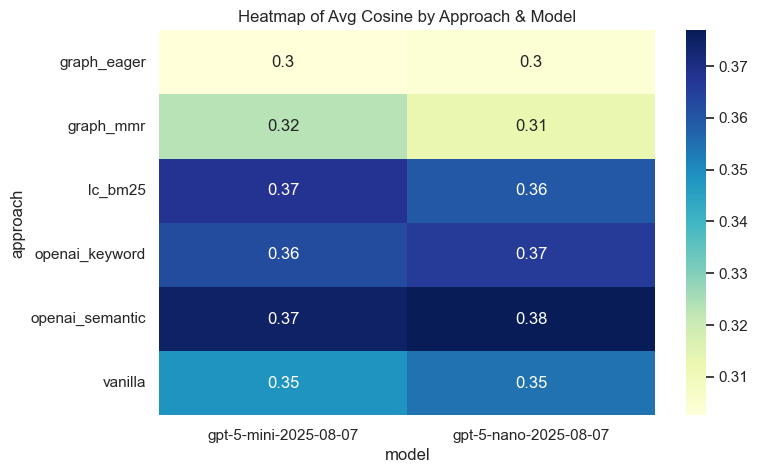

In [338]:

heatmap_df_pivot = heatmap_df.pivot(
    index="approach", 
    columns="model", 
    values="avg_cosine"
)
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_df_pivot, annot=True, cmap="YlGnBu")
plt.title("Heatmap of Avg Cosine by Approach & Model")
plt.show()

In [339]:
# =======================================
# Section 8: Evaluate Best Combinations
# =======================================

# Sort and display top combinations by correctness
best_correctness = agg_df.sort_values("pct_correctness_true", ascending=False)
best_helpfulness = agg_df.sort_values("pct_helpfulness_true", ascending=False)

print("\nTop combinations by % Correctness TRUE:")
display(best_correctness[[
    "approach", "model", "top_k", 
    "pct_correctness_true", "avg_cosine", "avg_rougeL", "avg_bleu"
]])

print("\nTop combinations by % Helpfulness TRUE:")
display(best_helpfulness[[
    "approach", "model", "top_k", 
    "pct_helpfulness_true", "avg_cosine", "avg_rougeL", "avg_bleu"
]])


Top combinations by % Correctness TRUE:


,approach,model,top_k,pct_correctness_true,avg_cosine,avg_rougeL,avg_bleu
13,openai_keyword,gpt-5-mini-2025-08-07,7,86.666667,0.361697,0.188480,0.057618
12,openai_keyword,gpt-5-mini-2025-08-07,3,83.333333,0.362981,0.203452,0.067041
17,openai_semantic,gpt-5-mini-2025-08-07,7,83.333333,0.369856,0.203863,0.075078
16,openai_semantic,gpt-5-mini-2025-08-07,3,81.666667,0.379911,0.218118,0.079534
21,vanilla,gpt-5-mini-2025-08-07,7,78.333333,0.360256,0.194056,0.065420
18,openai_semantic,gpt-5-nano-2025-08-07,3,76.666667,0.376737,0.263464,0.109651
8,lc_bm25,gpt-5-mini-2025-08-07,3,76.666667,0.366665,0.213207,0.077585
9,lc_bm25,gpt-5-mini-2025-08-07,7,75.000000,0.368714,0.192009,0.063715
15,openai_keyword,gpt-5-nano-2025-08-07,7,73.333333,0.366657,0.234396,0.077591
5,graph_mmr,gpt-5-mini-2025-08-07,7,70.000000,0.322273,0.184166,0.059939



Top combinations by % Helpfulness TRUE:


,approach,model,top_k,pct_helpfulness_true,avg_cosine,avg_rougeL,avg_bleu
21,vanilla,gpt-5-mini-2025-08-07,7,90.000000,0.360256,0.194056,0.065420
16,openai_semantic,gpt-5-mini-2025-08-07,3,90.000000,0.379911,0.218118,0.079534
19,openai_semantic,gpt-5-nano-2025-08-07,7,90.000000,0.377108,0.240732,0.085257
13,openai_keyword,gpt-5-mini-2025-08-07,7,88.333333,0.361697,0.188480,0.057618
17,openai_semantic,gpt-5-mini-2025-08-07,7,88.333333,0.369856,0.203863,0.075078
15,openai_keyword,gpt-5-nano-2025-08-07,7,86.666667,0.366657,0.234396,0.077591
14,openai_keyword,gpt-5-nano-2025-08-07,3,85.000000,0.365223,0.246771,0.078226
9,lc_bm25,gpt-5-mini-2025-08-07,7,83.333333,0.368714,0.192009,0.063715
18,openai_semantic,gpt-5-nano-2025-08-07,3,83.333333,0.376737,0.263464,0.109651
12,openai_keyword,gpt-5-mini-2025-08-07,3,81.666667,0.362981,0.203452,0.067041


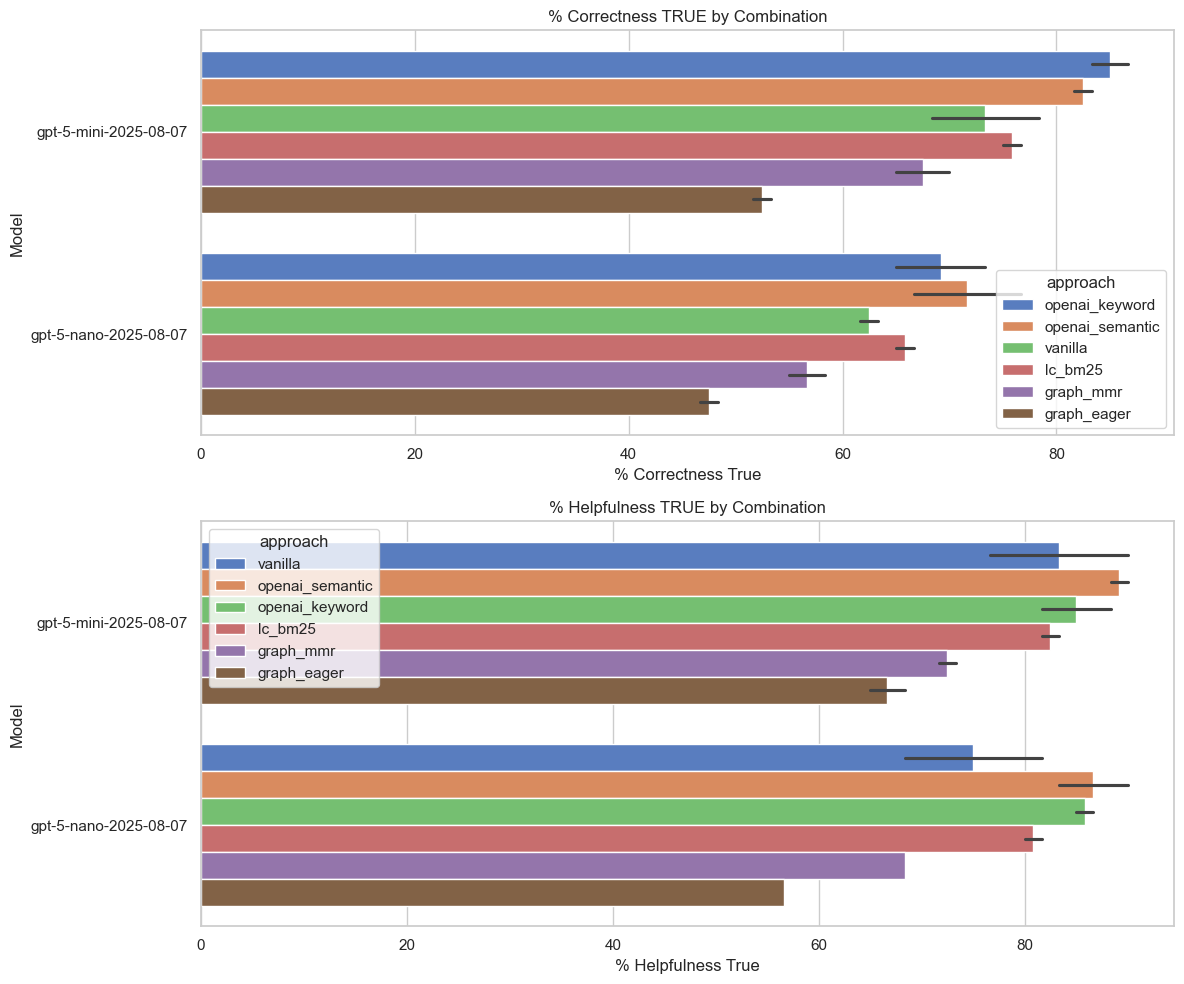

In [340]:
# =======================================
# Visual Comparison Bar Charts
# =======================================

# Combine metrics in one figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
sns.barplot(
    data=agg_df.sort_values("pct_correctness_true", ascending=False),
    x="pct_correctness_true", 
    y="model", 
    hue="approach", 
    ax=axes[0]
)
axes[0].set_title("% Correctness TRUE by Combination")
axes[0].set_xlabel("% Correctness True")
axes[0].set_ylabel("Model")

sns.barplot(
    data=agg_df.sort_values("pct_helpfulness_true", ascending=False),
    x="pct_helpfulness_true", 
    y="model", 
    hue="approach", 
    ax=axes[1]
)
axes[1].set_title("% Helpfulness TRUE by Combination")
axes[1].set_xlabel("% Helpfulness True")
axes[1].set_ylabel("Model")

plt.tight_layout()
plt.show()

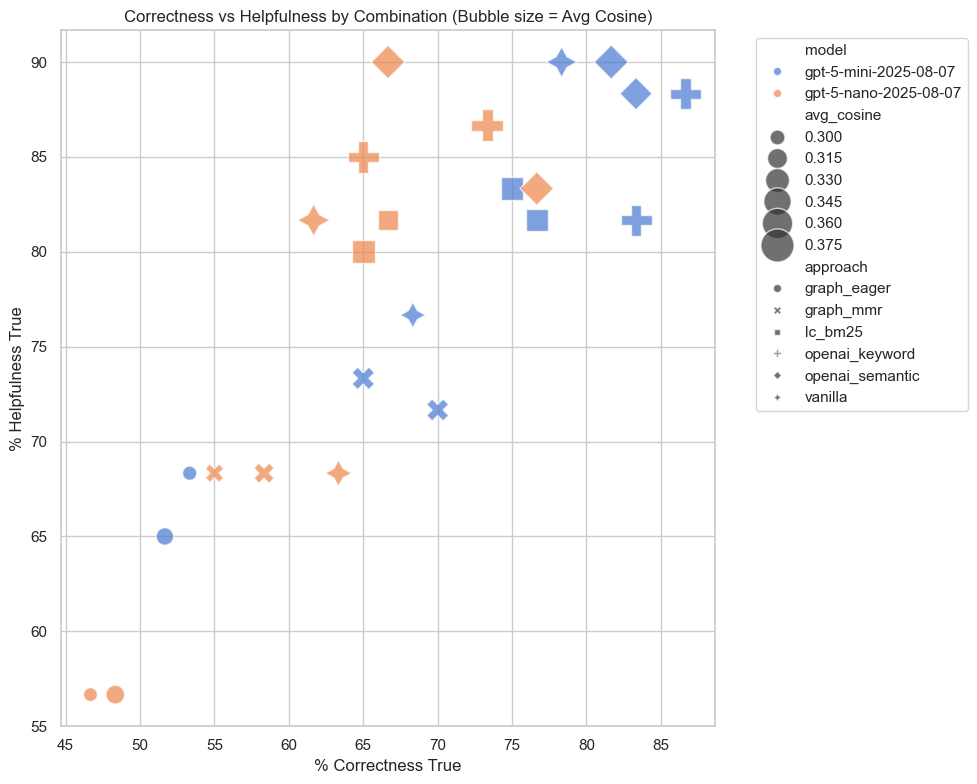

In [341]:
# =======================================
# Annotated Bubble Chart
# =======================================

# Bubble chart: each combination plotted by correctness vs helpfulness
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(
    data=agg_df,
    x="pct_correctness_true",
    y="pct_helpfulness_true",
    size="avg_cosine",
    hue="model",
    style="approach",
    sizes=(100, 600),
    alpha=0.7
)
plt.title("Correctness vs Helpfulness by Combination (Bubble size = Avg Cosine)")
plt.xlabel("% Correctness True")
plt.ylabel("% Helpfulness True")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [342]:

# =======================================
# Combined Scoring View
# =======================================

# Create a composite ranking score (normalized 0–1)
from sklearn.preprocessing import MinMaxScaler # type: ignore

scaler = MinMaxScaler()
agg_df[["score_correctness", "score_helpfulness"]] = scaler.fit_transform(
    agg_df[["pct_correctness_true", "pct_helpfulness_true"]]
)
agg_df["combined_score"] = (agg_df["score_correctness"] + agg_df["score_helpfulness"]) / 2

ranked = agg_df.sort_values("score_correctness", ascending=False)
ranked["rank"] = 0
print(agg_df.columns)

for idx, (i,row) in enumerate(ranked.iterrows()):
    ranked.loc[i, "rank"] = idx
print("\nRanked by Combined Correctness+Helpfulness Score:")
display(ranked[[
    "rank", "approach", "model", "top_k", "avg_latency_sec", "avg_meta_total_tokens", "avg_price_usd",
    "pct_correctness_true", "pct_helpfulness_true", "combined_score"
]])

Index(['approach', 'model', 'top_k', 'avg_meta_total_tokens', 'avg_cosine',
       'avg_rougeL', 'avg_bleu', 'avg_price_usd', 'avg_latency_sec',
       'true_correctness_count', 'total_correctness_count',
       'true_helpfulness_count', 'total_helpfulness_count',
       'pct_correctness_true', 'pct_helpfulness_true', 'score_correctness',
       'score_helpfulness', 'combined_score'],
      dtype='object')

Ranked by Combined Correctness+Helpfulness Score:


,rank,approach,model,top_k,avg_latency_sec,avg_meta_total_tokens,avg_price_usd,pct_correctness_true,pct_helpfulness_true,combined_score
13,0,openai_keyword,gpt-5-mini-2025-08-07,7,10.044333,18744.283333,0.037489,86.666667,88.333333,0.975000
12,1,openai_keyword,gpt-5-mini-2025-08-07,3,9.577833,8818.783333,0.017638,83.333333,81.666667,0.833333
17,2,openai_semantic,gpt-5-mini-2025-08-07,7,10.069500,18221.350000,0.036443,83.333333,88.333333,0.933333
16,3,openai_semantic,gpt-5-mini-2025-08-07,3,8.681500,8646.900000,0.017294,81.666667,90.000000,0.937500
21,4,vanilla,gpt-5-mini-2025-08-07,7,13.407500,11673.900000,0.023348,78.333333,90.000000,0.895833
18,5,openai_semantic,gpt-5-nano-2025-08-07,3,6.496500,8717.383333,0.003487,76.666667,83.333333,0.775000
8,6,lc_bm25,gpt-5-mini-2025-08-07,3,6.905167,9846.500000,0.019693,76.666667,81.666667,0.750000
9,7,lc_bm25,gpt-5-mini-2025-08-07,7,8.003333,9854.783333,0.019710,75.000000,83.333333,0.754167
15,8,openai_keyword,gpt-5-nano-2025-08-07,7,6.574000,18720.600000,0.007488,73.333333,86.666667,0.783333
5,9,graph_mmr,gpt-5-mini-2025-08-07,7,16.815667,4164.966667,0.008330,70.000000,71.666667,0.516667


In [343]:
# display(ranked[[
#     "rank", "approach", "model", "top_k", 
#     "pct_correctness_true", "pct_helpfulness_true", "combined_score"
# ]].head(5))

display(ranked[[
    "rank", "approach", "model", "top_k", "avg_latency_sec", "avg_meta_total_tokens", "avg_price_usd",
    "pct_correctness_true", "pct_helpfulness_true", "combined_score"
]].head(5))

,rank,approach,model,top_k,avg_latency_sec,avg_meta_total_tokens,avg_price_usd,pct_correctness_true,pct_helpfulness_true,combined_score
13,0,openai_keyword,gpt-5-mini-2025-08-07,7,10.044333,18744.283333,0.037489,86.666667,88.333333,0.975000
12,1,openai_keyword,gpt-5-mini-2025-08-07,3,9.577833,8818.783333,0.017638,83.333333,81.666667,0.833333
17,2,openai_semantic,gpt-5-mini-2025-08-07,7,10.069500,18221.350000,0.036443,83.333333,88.333333,0.933333
16,3,openai_semantic,gpt-5-mini-2025-08-07,3,8.681500,8646.900000,0.017294,81.666667,90.000000,0.937500
21,4,vanilla,gpt-5-mini-2025-08-07,7,13.407500,11673.900000,0.023348,78.333333,90.000000,0.895833


In [344]:
# =======================================
# Combined Latency View
# =======================================

# Create a composite ranking score (normalized 0–1)
from sklearn.preprocessing import MinMaxScaler # type: ignore

scaler = MinMaxScaler()
agg_df[["score_correctness", "score_helpfulness"]] = scaler.fit_transform(
    agg_df[["pct_correctness_true", "pct_helpfulness_true"]]
)
agg_df["combined_score"] = (agg_df["score_correctness"] + agg_df["score_helpfulness"]) / 2

ranked = agg_df.sort_values("avg_latency_sec", ascending=True)
ranked["rank"] = 0
print(agg_df.columns)

for idx, (i,row) in enumerate(ranked.iterrows()):
    ranked.loc[i, "rank"] = idx
print("\nRanked by Combined Latency Score:")
display(ranked[[
    "rank", "approach", "model", "top_k", "avg_latency_sec", "avg_meta_total_tokens", "avg_price_usd",
    "pct_correctness_true", "pct_helpfulness_true", "combined_score"
]])

Index(['approach', 'model', 'top_k', 'avg_meta_total_tokens', 'avg_cosine',
       'avg_rougeL', 'avg_bleu', 'avg_price_usd', 'avg_latency_sec',
       'true_correctness_count', 'total_correctness_count',
       'true_helpfulness_count', 'total_helpfulness_count',
       'pct_correctness_true', 'pct_helpfulness_true', 'score_correctness',
       'score_helpfulness', 'combined_score'],
      dtype='object')

Ranked by Combined Latency Score:


,rank,approach,model,top_k,avg_latency_sec,avg_meta_total_tokens,avg_price_usd,pct_correctness_true,pct_helpfulness_true,combined_score
11,0,lc_bm25,gpt-5-nano-2025-08-07,7,4.684667,9876.983333,0.003951,65.000000,80.000000,0.579167
10,1,lc_bm25,gpt-5-nano-2025-08-07,3,4.831500,9863.166667,0.003945,66.666667,81.666667,0.625000
18,2,openai_semantic,gpt-5-nano-2025-08-07,3,6.496500,8717.383333,0.003487,76.666667,83.333333,0.775000
15,3,openai_keyword,gpt-5-nano-2025-08-07,7,6.574000,18720.600000,0.007488,73.333333,86.666667,0.783333
8,4,lc_bm25,gpt-5-mini-2025-08-07,3,6.905167,9846.500000,0.019693,76.666667,81.666667,0.750000
19,5,openai_semantic,gpt-5-nano-2025-08-07,7,7.080500,18225.883333,0.007290,66.666667,90.000000,0.750000
9,6,lc_bm25,gpt-5-mini-2025-08-07,7,8.003333,9854.783333,0.019710,75.000000,83.333333,0.754167
14,7,openai_keyword,gpt-5-nano-2025-08-07,3,8.043500,8824.750000,0.003530,65.000000,85.000000,0.654167
16,8,openai_semantic,gpt-5-mini-2025-08-07,3,8.681500,8646.900000,0.017294,81.666667,90.000000,0.937500
12,9,openai_keyword,gpt-5-mini-2025-08-07,3,9.577833,8818.783333,0.017638,83.333333,81.666667,0.833333


In [345]:
# =======================================
# Combined Token View
# =======================================

# Create a composite ranking score (normalized 0–1)
from sklearn.preprocessing import MinMaxScaler # type: ignore

scaler = MinMaxScaler()
agg_df[["score_correctness", "score_helpfulness"]] = scaler.fit_transform(
    agg_df[["pct_correctness_true", "pct_helpfulness_true"]]
)
agg_df["combined_score"] = (agg_df["score_correctness"] + agg_df["score_helpfulness"]) / 2

ranked = agg_df.sort_values("avg_meta_total_tokens", ascending=True)
ranked["rank"] = 0
print(agg_df.columns)

for idx, (i,row) in enumerate(ranked.iterrows()):
    ranked.loc[i, "rank"] = idx
print("\nRanked by Token Score:")
display(ranked[[
    "rank", "approach", "model", "top_k", "avg_latency_sec", "avg_meta_total_tokens", "avg_price_usd",
    "pct_correctness_true", "pct_helpfulness_true", "combined_score"
]])

Index(['approach', 'model', 'top_k', 'avg_meta_total_tokens', 'avg_cosine',
       'avg_rougeL', 'avg_bleu', 'avg_price_usd', 'avg_latency_sec',
       'true_correctness_count', 'total_correctness_count',
       'true_helpfulness_count', 'total_helpfulness_count',
       'pct_correctness_true', 'pct_helpfulness_true', 'score_correctness',
       'score_helpfulness', 'combined_score'],
      dtype='object')

Ranked by Token Score:


,rank,approach,model,top_k,avg_latency_sec,avg_meta_total_tokens,avg_price_usd,pct_correctness_true,pct_helpfulness_true,combined_score
0,0,graph_eager,gpt-5-mini-2025-08-07,3,15.681833,2414.716667,0.004829,51.666667,65.000000,0.187500
1,1,graph_eager,gpt-5-mini-2025-08-07,7,16.094500,2419.816667,0.004840,53.333333,68.333333,0.258333
2,2,graph_eager,gpt-5-nano-2025-08-07,3,13.893500,2432.500000,0.000973,46.666667,56.666667,0.000000
3,3,graph_eager,gpt-5-nano-2025-08-07,7,14.213167,2443.050000,0.000977,48.333333,56.666667,0.020833
4,4,graph_mmr,gpt-5-mini-2025-08-07,3,16.722000,4146.933333,0.008294,65.000000,73.333333,0.479167
5,5,graph_mmr,gpt-5-mini-2025-08-07,7,16.815667,4164.966667,0.008330,70.000000,71.666667,0.516667
7,6,graph_mmr,gpt-5-nano-2025-08-07,7,14.052167,4169.150000,0.001668,55.000000,68.333333,0.279167
6,7,graph_mmr,gpt-5-nano-2025-08-07,3,13.810500,4180.566667,0.001672,58.333333,68.333333,0.320833
22,8,vanilla,gpt-5-nano-2025-08-07,3,9.933667,5571.283333,0.002229,63.333333,68.333333,0.383333
20,9,vanilla,gpt-5-mini-2025-08-07,3,12.403000,5574.483333,0.011149,68.333333,76.666667,0.570833


In [346]:
# =======================================
# Combined Price View
# =======================================

# Create a composite ranking score (normalized 0–1)
from sklearn.preprocessing import MinMaxScaler # type: ignore

scaler = MinMaxScaler()
agg_df[["score_correctness", "score_helpfulness"]] = scaler.fit_transform(
    agg_df[["pct_correctness_true", "pct_helpfulness_true"]]
)
agg_df["combined_score"] = (agg_df["score_correctness"] + agg_df["score_helpfulness"]) / 2

ranked = agg_df.sort_values("avg_price_usd", ascending=True)
ranked["rank"] = 0
print(agg_df.columns)

for idx, (i,row) in enumerate(ranked.iterrows()):
    ranked.loc[i, "rank"] = idx
print("\nRanked by Price Score:")
display(ranked[[
    "rank", "approach", "model", "top_k", "avg_latency_sec", "avg_meta_total_tokens", "avg_price_usd",
    "pct_correctness_true", "pct_helpfulness_true", "combined_score"
]])

Index(['approach', 'model', 'top_k', 'avg_meta_total_tokens', 'avg_cosine',
       'avg_rougeL', 'avg_bleu', 'avg_price_usd', 'avg_latency_sec',
       'true_correctness_count', 'total_correctness_count',
       'true_helpfulness_count', 'total_helpfulness_count',
       'pct_correctness_true', 'pct_helpfulness_true', 'score_correctness',
       'score_helpfulness', 'combined_score'],
      dtype='object')

Ranked by Price Score:


,rank,approach,model,top_k,avg_latency_sec,avg_meta_total_tokens,avg_price_usd,pct_correctness_true,pct_helpfulness_true,combined_score
2,0,graph_eager,gpt-5-nano-2025-08-07,3,13.893500,2432.500000,0.000973,46.666667,56.666667,0.000000
3,1,graph_eager,gpt-5-nano-2025-08-07,7,14.213167,2443.050000,0.000977,48.333333,56.666667,0.020833
7,2,graph_mmr,gpt-5-nano-2025-08-07,7,14.052167,4169.150000,0.001668,55.000000,68.333333,0.279167
6,3,graph_mmr,gpt-5-nano-2025-08-07,3,13.810500,4180.566667,0.001672,58.333333,68.333333,0.320833
22,4,vanilla,gpt-5-nano-2025-08-07,3,9.933667,5571.283333,0.002229,63.333333,68.333333,0.383333
18,5,openai_semantic,gpt-5-nano-2025-08-07,3,6.496500,8717.383333,0.003487,76.666667,83.333333,0.775000
14,6,openai_keyword,gpt-5-nano-2025-08-07,3,8.043500,8824.750000,0.003530,65.000000,85.000000,0.654167
10,7,lc_bm25,gpt-5-nano-2025-08-07,3,4.831500,9863.166667,0.003945,66.666667,81.666667,0.625000
11,8,lc_bm25,gpt-5-nano-2025-08-07,7,4.684667,9876.983333,0.003951,65.000000,80.000000,0.579167
23,9,vanilla,gpt-5-nano-2025-08-07,7,10.704167,11688.233333,0.004675,61.666667,81.666667,0.562500


In [347]:

# =======================================
# Combined TOTAL View
# =======================================

# Create a composite ranking score (normalized 0–1)
from sklearn.preprocessing import MinMaxScaler # type: ignore

scaler = MinMaxScaler()
agg_df[["score_correctness", "score_helpfulness", "price_usd", "latency_sec"]] = scaler.fit_transform(
    agg_df[["pct_correctness_true", "pct_helpfulness_true", "avg_price_usd", "avg_latency_sec"]]
)
agg_df["combined_score"] = (agg_df["score_correctness"] + agg_df["score_helpfulness"] + agg_df["price_usd"] + agg_df["latency_sec"]) / 4

ranked = agg_df.sort_values("combined_score", ascending=False)
ranked["rank"] = 0
print(agg_df.columns)

for idx, (i,row) in enumerate(ranked.iterrows()):
    ranked.loc[i, "rank"] = idx
print("\nRanked by Combined Correctness+Helpfulness+Price+Latency Score:")
display(ranked[[
    "rank", "approach", "model", "top_k", "avg_latency_sec", "avg_meta_total_tokens", "avg_price_usd",
    "pct_correctness_true", "pct_helpfulness_true", "combined_score"
]])

Index(['approach', 'model', 'top_k', 'avg_meta_total_tokens', 'avg_cosine',
       'avg_rougeL', 'avg_bleu', 'avg_price_usd', 'avg_latency_sec',
       'true_correctness_count', 'total_correctness_count',
       'true_helpfulness_count', 'total_helpfulness_count',
       'pct_correctness_true', 'pct_helpfulness_true', 'score_correctness',
       'score_helpfulness', 'combined_score', 'price_usd', 'latency_sec'],
      dtype='object')

Ranked by Combined Correctness+Helpfulness+Price+Latency Score:


,rank,approach,model,top_k,avg_latency_sec,avg_meta_total_tokens,avg_price_usd,pct_correctness_true,pct_helpfulness_true,combined_score
13,0,openai_keyword,gpt-5-mini-2025-08-07,7,10.044333,18744.283333,0.037489,86.666667,88.333333,0.847954
17,1,openai_semantic,gpt-5-mini-2025-08-07,7,10.069500,18221.350000,0.036443,83.333333,88.333333,0.820479
21,2,vanilla,gpt-5-mini-2025-08-07,7,13.407500,11673.900000,0.023348,78.333333,90.000000,0.780867
16,3,openai_semantic,gpt-5-mini-2025-08-07,3,8.681500,8646.900000,0.017294,81.666667,90.000000,0.662857
12,4,openai_keyword,gpt-5-mini-2025-08-07,3,9.577833,8818.783333,0.017638,83.333333,81.666667,0.631599
9,5,lc_bm25,gpt-5-mini-2025-08-07,7,8.003333,9854.783333,0.019710,75.000000,83.333333,0.573754
5,6,graph_mmr,gpt-5-mini-2025-08-07,7,16.815667,4164.966667,0.008330,70.000000,71.666667,0.558702
8,7,lc_bm25,gpt-5-mini-2025-08-07,3,6.905167,9846.500000,0.019693,76.666667,81.666667,0.548925
4,8,graph_mmr,gpt-5-mini-2025-08-07,3,16.722000,4146.933333,0.008294,65.000000,73.333333,0.537775
20,9,vanilla,gpt-5-mini-2025-08-07,3,12.403000,5574.483333,0.011149,68.333333,76.666667,0.514148



Question-Level Summary (top 15 by correctness):


,question,pct_correctness_true,pct_helpfulness_true,avg_cosine,avg_rougeL,avg_bleu,avg_meta_total_tokens,avg_price_usd,avg_latency_sec
1,Can I connect or disconnect my teach pendant w...,100.0,100.000000,0.550129,0.369395,0.185813,8256.833333,0.009929,8.024167
2,Can I skip setting a password for the safety s...,100.0,100.000000,0.265912,0.185206,0.040454,7872.208333,0.009400,10.658333
6,How can I reduce the force applied to the oper...,100.0,100.000000,0.381032,0.207205,0.041373,8211.666667,0.009833,10.347083
7,How can I set up my active program so that I o...,100.0,100.000000,0.354232,0.121789,0.007889,10521.958333,0.012624,12.803750
9,How do I ensure the robot elbow and tool remai...,100.0,100.000000,0.385594,0.106636,0.012368,9356.666667,0.011103,13.447083
27,What are the limitations of using safety planes?,100.0,87.500000,0.453634,0.171618,0.040485,10172.875000,0.012257,12.582500
26,What are the four collaborative operation tech...,100.0,100.000000,0.446761,0.406209,0.037488,7288.291667,0.008723,9.218333
13,How do I set the admin password?,100.0,100.000000,0.633227,0.321829,0.033206,7410.083333,0.008873,10.086250
59,Why is the robot arm moving slowly or stopping...,100.0,100.000000,0.241750,0.098317,0.008863,9812.708333,0.011791,14.633750
55,Who should perform the risk assessment for the...,100.0,100.000000,0.663504,0.409191,0.191433,7077.000000,0.008496,9.000000


/tmp/ipykernel_187992/4035156860.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_187992/4035156860.py:54: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


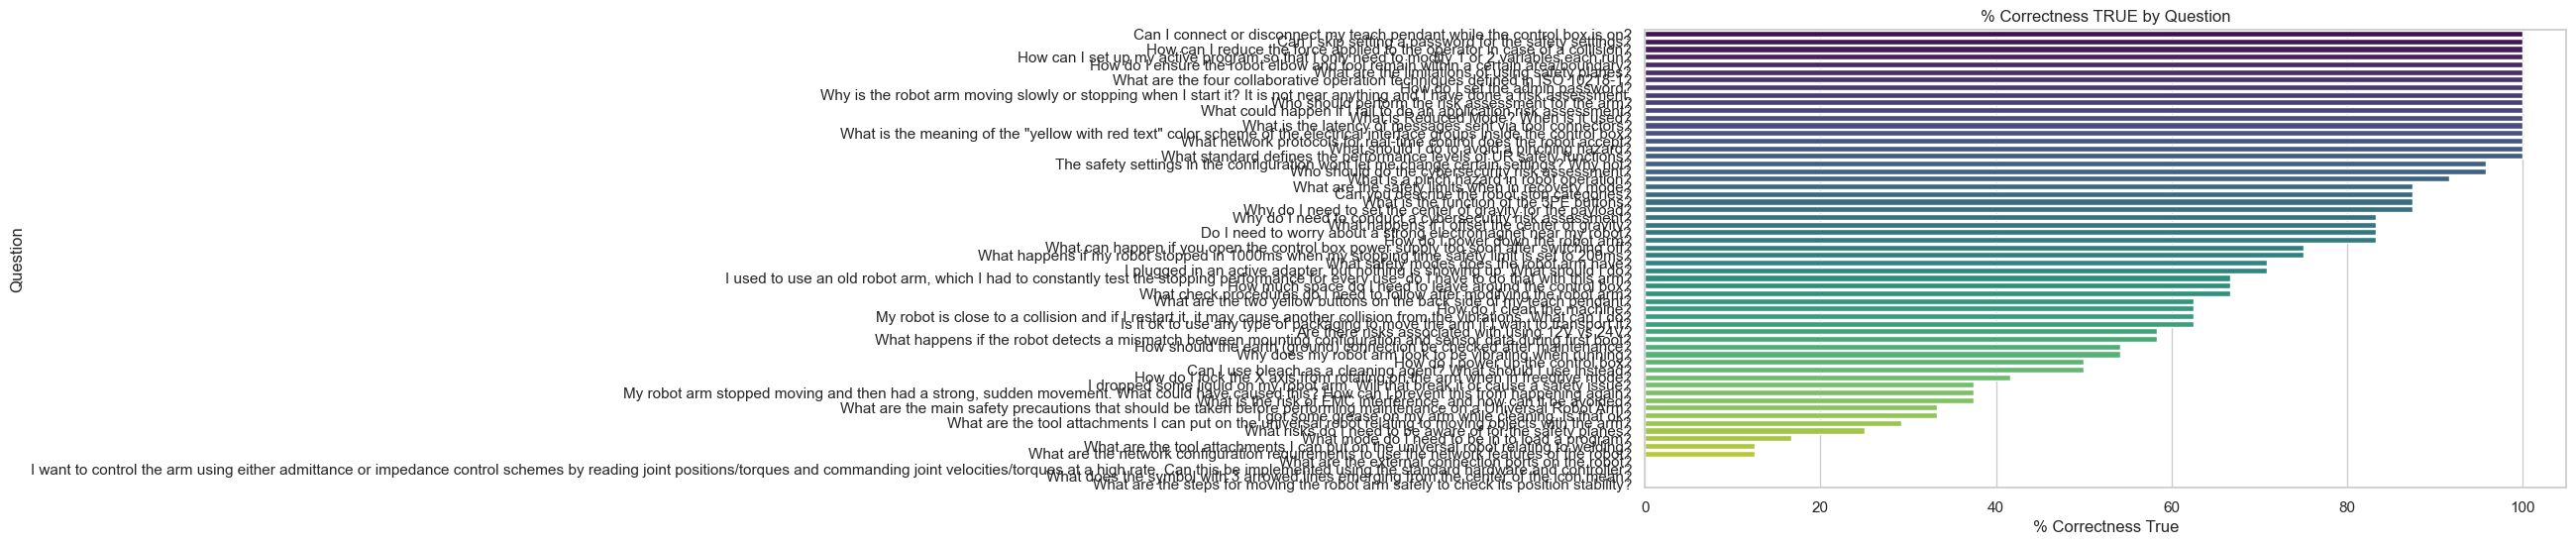

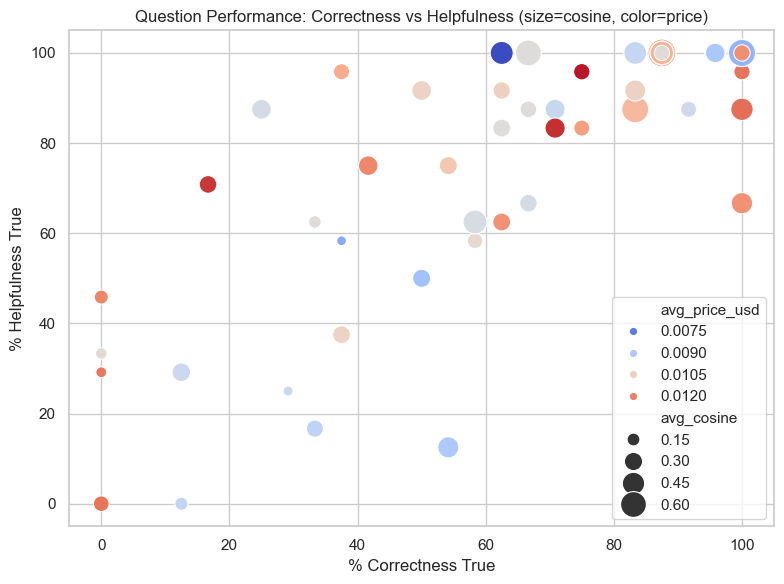


Question x Model x Approach Summary (Top 20 by Correctness):


,question,approach,model,avg_latency_sec,avg_meta_total_tokens,avg_price_usd,pct_correctness_true,pct_helpfulness_true,avg_cosine,avg_rougeL,avg_bleu,correctness_per_dollar
700,Why does my robot arm look to be vibrating whe...,openai_semantic,gpt-5-mini-2025-08-07,13.420,13396.5,0.026793,100.0,100.0,0.482082,0.179719,0.021477,3732.318143
699,Why does my robot arm look to be vibrating whe...,openai_keyword,gpt-5-mini-2025-08-07,9.165,13234.0,0.026468,100.0,100.0,0.266539,0.130112,0.009989,3778.147197
698,Why does my robot arm look to be vibrating whe...,lc_bm25,gpt-5-mini-2025-08-07,6.135,12398.5,0.024797,100.0,100.0,0.431296,0.165565,0.029286,4032.745897
695,Why do I need to set the center of gravity for...,vanilla,gpt-5-nano-2025-08-07,11.310,7795.0,0.003118,100.0,100.0,0.233025,0.104190,0.037941,32071.840924
694,Why do I need to set the center of gravity for...,openai_semantic,gpt-5-nano-2025-08-07,8.055,13574.0,0.005430,100.0,100.0,0.210595,0.112500,0.015962,18417.562988
691,Why do I need to set the center of gravity for...,graph_mmr,gpt-5-nano-2025-08-07,11.205,4117.0,0.001647,100.0,100.0,0.225732,0.110985,0.029471,60723.828030
690,Why do I need to set the center of gravity for...,graph_eager,gpt-5-nano-2025-08-07,9.955,2623.0,0.001049,100.0,100.0,0.239757,0.115441,0.038659,95310.712924
689,Why do I need to set the center of gravity for...,vanilla,gpt-5-mini-2025-08-07,13.965,7751.5,0.015503,100.0,100.0,0.220648,0.100489,0.025050,6450.364446
688,Why do I need to set the center of gravity for...,openai_semantic,gpt-5-mini-2025-08-07,8.835,13267.5,0.026535,100.0,100.0,0.167568,0.098595,0.021679,3768.607500
31,Can I skip setting a password for the safety s...,graph_mmr,gpt-5-nano-2025-08-07,13.585,4653.0,0.001861,100.0,100.0,0.159317,0.200401,0.021120,53728.777133


In [353]:
question_df = (
    df.groupby("question")
      .agg(
          avg_meta_total_tokens=("meta_total_tokens", "mean"),
          avg_cosine=("cosine", "mean"),
          avg_rougeL=("rougeL", "mean"),
          avg_bleu=("bleu", "mean"),
          avg_price_usd=("price_usd", "mean"),
          avg_latency_sec=("total_elapsed_time_sec", "mean"),
          true_correctness_count=("judge_answer_correctness_vs_ref", "sum"),
          total_correctness_count=("judge_answer_correctness_vs_ref", "count"),
          true_helpfulness_count=("judge_answer_helpfulness", "sum"),
          total_helpfulness_count=("judge_answer_helpfulness", "count"),
      )
      .reset_index()
)

# Compute derived percentages
question_df["pct_correctness_true"] = (
    question_df["true_correctness_count"] / question_df["total_correctness_count"] * 100
)
question_df["pct_helpfulness_true"] = (
    question_df["true_helpfulness_count"] / question_df["total_helpfulness_count"] * 100
)

# Display table (limit to top 15 by default)
print("\nQuestion-Level Summary (top 15 by correctness):")
display(
    question_df.sort_values("pct_correctness_true", ascending=False)
               .head(15)[[
                   "question",
                   "pct_correctness_true",
                   "pct_helpfulness_true",
                   "avg_cosine",
                   "avg_rougeL",
                   "avg_bleu",
                   "avg_meta_total_tokens",
                   "avg_price_usd",
                   "avg_latency_sec"
               ]]
)

# --- Bar chart: Correctness per question ---
plt.figure(figsize=(12, 6))
sns.barplot(
    data=question_df.sort_values("pct_correctness_true", ascending=False),
    x="pct_correctness_true",
    y="question",
    palette="viridis"
)
plt.title("% Correctness TRUE by Question")
plt.xlabel("% Correctness True")
plt.ylabel("Question")
plt.tight_layout()
plt.show()

# --- Scatterplot: Helpfulness vs Correctness per question ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=question_df,
    x="pct_correctness_true",
    y="pct_helpfulness_true",
    size="avg_cosine",
    hue="avg_price_usd",
    sizes=(50, 400),
    palette="coolwarm",
)
plt.title("Question Performance: Correctness vs Helpfulness (size=cosine, color=price)")
plt.xlabel("% Correctness True")
plt.ylabel("% Helpfulness True")
plt.tight_layout()
plt.show()

# --- Optional ranking by cost efficiency ---
question_df["correctness_per_dollar"] = (
    question_df["pct_correctness_true"] / question_df["avg_price_usd"]
)

# display(
#     question_df.sort_values("correctness_per_dollar", ascending=False)[[
#                    "question",
#                    "pct_correctness_true",
#                    "avg_price_usd",
#                    "correctness_per_dollar"
#                ]]
# )

# display(
#     question_df[[
#                    "question",
#                    "pct_correctness_true",
#                    "avg_price_usd",
#                    "correctness_per_dollar"
#                ]]
# )

# display(
#     question_df[[
#         "question",
#         "avg_latency_sec",
#         "avg_meta_total_tokens",
#         "avg_price_usd",
#         "pct_correctness_true",
#         "pct_helpfulness_true",
#         "avg_cosine",
#         "avg_rougeL",
#         "avg_bleu",
#         "correctness_per_dollar"
#     ]].sort_values("pct_correctness_true", ascending=False)
# )

# =======================================
# 🧩 Question × Model × Approach Summary
# =======================================

# Group by question, model, and approach
question_model_df = (
    df.groupby(["question", "model", "approach"])
      .agg(
          avg_meta_total_tokens=("meta_total_tokens", "mean"),
          avg_cosine=("cosine", "mean"),
          avg_rougeL=("rougeL", "mean"),
          avg_bleu=("bleu", "mean"),
          avg_price_usd=("price_usd", "mean"),
          avg_latency_sec=("total_elapsed_time_sec", "mean"),
          true_correctness_count=("judge_answer_correctness_vs_ref", "sum"),
          total_correctness_count=("judge_answer_correctness_vs_ref", "count"),
          true_helpfulness_count=("judge_answer_helpfulness", "sum"),
          total_helpfulness_count=("judge_answer_helpfulness", "count"),
      )
      .reset_index()
)

# Derived percentages and efficiency
question_model_df["pct_correctness_true"] = (
    question_model_df["true_correctness_count"] / question_model_df["total_correctness_count"] * 100
)
question_model_df["pct_helpfulness_true"] = (
    question_model_df["true_helpfulness_count"] / question_model_df["total_helpfulness_count"] * 100
)
question_model_df["correctness_per_dollar"] = (
    question_model_df["pct_correctness_true"] / question_model_df["avg_price_usd"]
)

# --- Display ---
print("\nQuestion x Model x Approach Summary (Top 20 by Correctness):")
display(
    question_model_df[[
        "question",
        "approach",
        "model",
        "avg_latency_sec",
        "avg_meta_total_tokens",
        "avg_price_usd",
        "pct_correctness_true",
        "pct_helpfulness_true",
        "avg_cosine",
        "avg_rougeL",
        "avg_bleu",
        "correctness_per_dollar"
    ]].sort_values("pct_correctness_true", ascending=False).head(20)
)



Question × Approach Summary (Top 20 by Correctness):


,question,approach,avg_latency_sec,avg_meta_total_tokens,avg_price_usd,pct_correctness_true,pct_helpfulness_true,avg_cosine,avg_rougeL,avg_bleu,correctness_per_dollar
359,Why is the robot arm moving slowly or stopping...,vanilla,14.1250,8728.75,0.010492,100.0,100.0,0.241645,0.098958,0.005175,9531.525521
358,Why is the robot arm moving slowly or stopping...,openai_semantic,11.2050,16443.00,0.019861,100.0,100.0,0.253210,0.092140,0.013676,5035.043906
357,Why is the robot arm moving slowly or stopping...,openai_keyword,13.5925,15198.00,0.018231,100.0,100.0,0.243307,0.080684,0.008095,5485.102462
2,Are there risks associated with using 12V vs 24V?,lc_bm25,7.4750,9628.50,0.011497,100.0,100.0,0.257197,0.091803,0.005439,8697.921197
3,Are there risks associated with using 12V vs 24V?,openai_keyword,11.0275,15095.25,0.018170,100.0,100.0,0.243425,0.119403,0.008267,5503.547036
4,Are there risks associated with using 12V vs 24V?,openai_semantic,9.6100,13497.75,0.016222,100.0,100.0,0.269894,0.107984,0.006153,6164.506007
341,Why do I need to conduct a cybersecurity risk ...,vanilla,7.9325,6434.50,0.007691,100.0,100.0,0.546786,0.420907,0.307772,13002.210376
340,Why do I need to conduct a cybersecurity risk ...,openai_semantic,5.6725,12823.50,0.015405,100.0,100.0,0.574373,0.432756,0.302628,6491.567454
339,Why do I need to conduct a cybersecurity risk ...,openai_keyword,7.1700,12878.75,0.015533,100.0,100.0,0.459817,0.347355,0.207680,6437.864946
338,Why do I need to conduct a cybersecurity risk ...,lc_bm25,4.1700,9366.75,0.011269,100.0,100.0,0.497491,0.366685,0.263896,8873.823109


/tmp/ipykernel_187992/3581831823.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


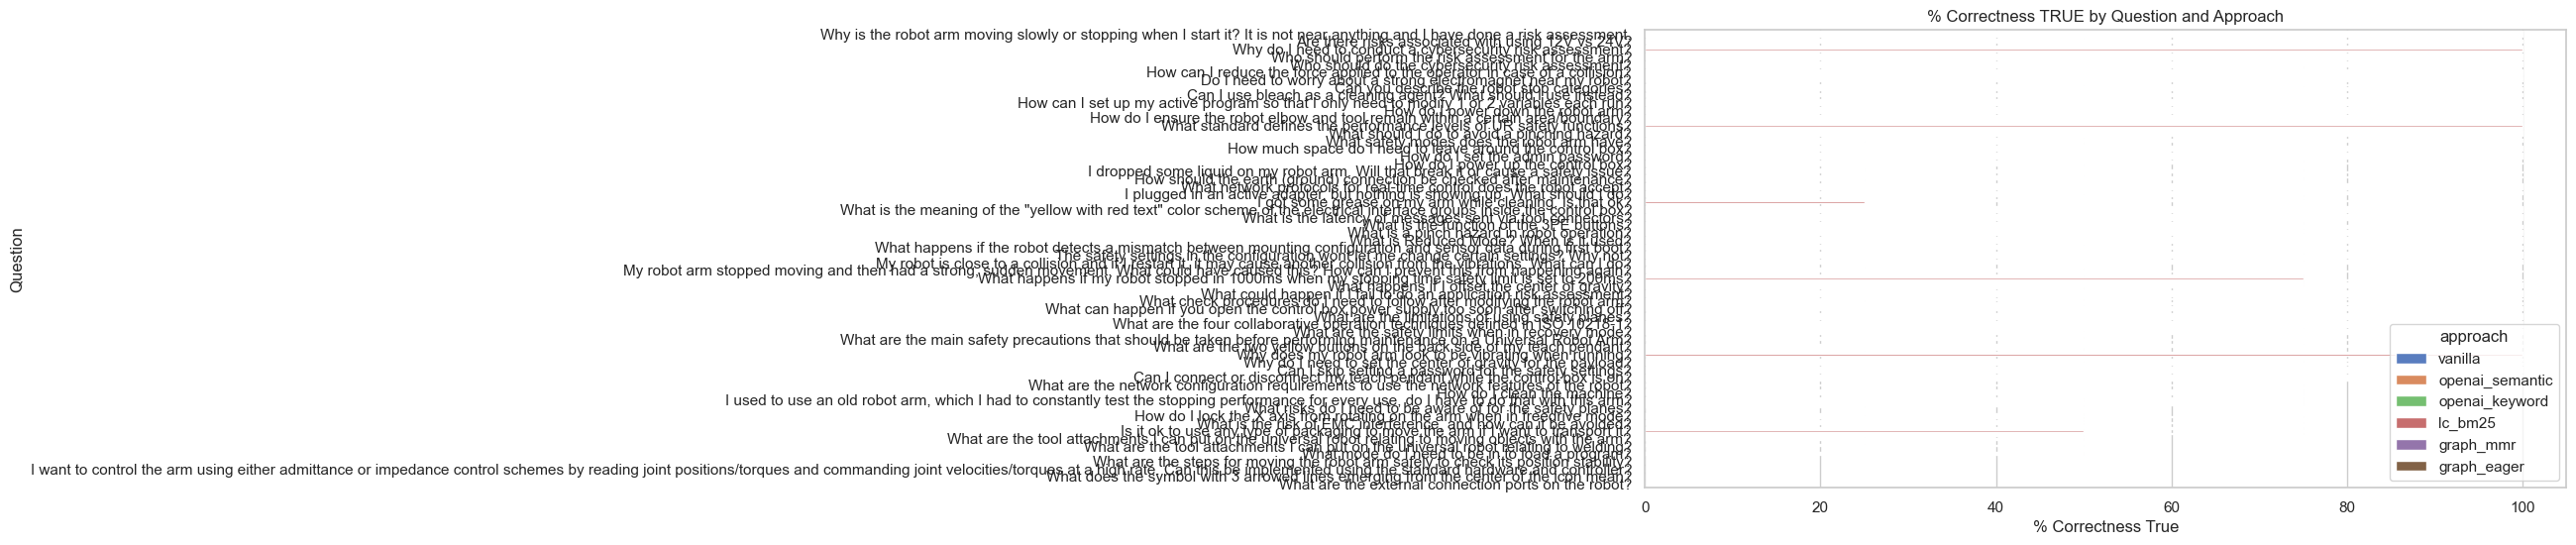

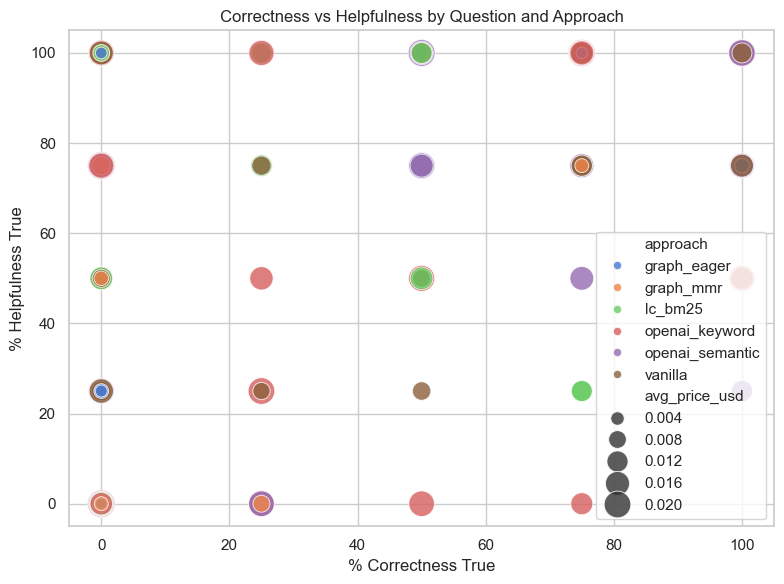


Average Performance per Approach Across All Questions:


,approach,pct_correctness_true,pct_helpfulness_true,avg_price_usd,avg_latency_sec
4,openai_semantic,77.083333,87.916667,0.016128,8.082000
3,openai_keyword,77.083333,85.416667,0.016536,8.559917
2,lc_bm25,70.833333,81.666667,0.011825,6.106167
5,vanilla,67.916667,79.166667,0.010350,11.612083
1,graph_mmr,62.083333,70.416667,0.004991,15.350083
0,graph_eager,50.000000,61.666667,0.002905,14.970750


In [357]:

# Group by question and approach
question_approach_df = (
    df.groupby(["question", "approach"])
      .agg(
          avg_meta_total_tokens=("meta_total_tokens", "mean"),
          avg_cosine=("cosine", "mean"),
          avg_rougeL=("rougeL", "mean"),
          avg_bleu=("bleu", "mean"),
          avg_price_usd=("price_usd", "mean"),
          avg_latency_sec=("total_elapsed_time_sec", "mean"),
          true_correctness_count=("judge_answer_correctness_vs_ref", "sum"),
          total_correctness_count=("judge_answer_correctness_vs_ref", "count"),
          true_helpfulness_count=("judge_answer_helpfulness", "sum"),
          total_helpfulness_count=("judge_answer_helpfulness", "count"),
      )
      .reset_index()
)

# --- Derived metrics ---
question_approach_df["pct_correctness_true"] = (
    question_approach_df["true_correctness_count"]
    / question_approach_df["total_correctness_count"]
    * 100
)
question_approach_df["pct_helpfulness_true"] = (
    question_approach_df["true_helpfulness_count"]
    / question_approach_df["total_helpfulness_count"]
    * 100
)
question_approach_df["correctness_per_dollar"] = (
    question_approach_df["pct_correctness_true"] / question_approach_df["avg_price_usd"]
)

# --- Display table ---
print("\nQuestion × Approach Summary (Top 20 by Correctness):")
display(
    question_approach_df[[
        "question",
        "approach",
        "avg_latency_sec",
        "avg_meta_total_tokens",
        "avg_price_usd",
        "pct_correctness_true",
        "pct_helpfulness_true",
        "avg_cosine",
        "avg_rougeL",
        "avg_bleu",
        "correctness_per_dollar",
    ]].sort_values("pct_correctness_true", ascending=False).head(20)
)

# --- Correctness per approach for each question ---
plt.figure(figsize=(12, 6))
sns.barplot(
    data=question_approach_df.sort_values("pct_correctness_true", ascending=False),
    x="pct_correctness_true",
    y="question",
    hue="approach"
)
plt.title("% Correctness TRUE by Question and Approach")
plt.xlabel("% Correctness True")
plt.ylabel("Question")
plt.tight_layout()
plt.show()

# --- Scatterplot: Helpfulness vs Correctness ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=question_approach_df,
    x="pct_correctness_true",
    y="pct_helpfulness_true",
    hue="approach",
    size="avg_price_usd",
    sizes=(50, 400),
    alpha=0.8,
)
plt.title("Correctness vs Helpfulness by Question and Approach")
plt.xlabel("% Correctness True")
plt.ylabel("% Helpfulness True")
plt.tight_layout()
plt.show()

# --- Optional: Average performance per approach across all questions ---
approach_summary = (
    question_approach_df.groupby("approach")
    [["pct_correctness_true", "pct_helpfulness_true", "avg_price_usd", "avg_latency_sec"]]
    .mean()
    .reset_index()
)
print("\nAverage Performance per Approach Across All Questions:")
display(approach_summary.sort_values("pct_correctness_true", ascending=False))
